In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, copy, tqdm, pickle, tarfile
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from alerts import get_alerts
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle
import seaborn as sns
from astropy.time import Time

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.signal import savgol_filter

from flarestack.cosmo import get_rate, define_cosmology_functions
plt.style.use('tableau-colorblind10')

No scratch directory has been set. Using home directory as default.


## Define some style parameters

In [2]:
rates = [
    #("TDE", get_rate("tde")),
    ("GRB", get_rate("GRB")),
#     ("TDE (Jetted)", get_rate("tde", rate_name="sun_15_jetted")),
    #("CCSN (Madau)", get_rate("ccsn", rate_name="madau_14", evolution_name="madau_14", kcc_name="madau_14")),
    ("SFR", get_rate("ccsn", rate_name="strolger_15", evolution_name="strolger_15", kcc_name="strolger_15")),
]

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

colors = {
    "TDE": CB_color_cycle[0],
    "GRB": CB_color_cycle[1],
    "CCSN (Madau)": CB_color_cycle[3],
    "CCSN (Strolger)": CB_color_cycle[5],
    "CCSN": CB_color_cycle[5],
    "SFR": CB_color_cycle[5]
}

In [3]:
nsteps = 1e4
zrange, step = np.linspace(0.0, 800, int(nsteps + 1), retstep=True)
cdf_mpc = dict()
zplot = 0.5*(zrange[1:] + zrange[:-1])
dlum_plot = cosmo.luminosity_distance(zplot)

for label, rate in rates:
    
    rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = \
            define_cosmology_functions(rate, 1., gamma=2.0)

    y = [0] + [x.value for x in cumulative_nu_flux(zplot)]
    y = np.array(y)/y[-1]
    dls = [0.] + [dl.value for dl in dlum_plot[1:]]
    cdf_mpc[label] = interp1d(dls, [0.] + list(y))

In [4]:
average_absolute_magnitudes = {
    'TDE': -19.5,
    'SN IIn': -18.53
#     'SN Ib': -17.45,
#     'SN Ic': -17.66,
    
}

mags_labels = {
    'SN IIn': 'CCSN',
    'TDE': 'TDE'
}

mag_label_map = np.array([
    ('SN IIn', 'CCSN'),
    ('TDE', 'TDE'),
    ('GRB', 'GRB'),
    ('SN IIn', 'SFR')
])

## Define some general functions

In [5]:
def abs_mag(z, lim_mag):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag.value

def max_dl(ab_mag, lim_mag):
    
    dl = (10.**(0.2*(lim_mag - ab_mag))) * (10.*u.pc)
    
    return dl.to(u.Mpc)

def abs_mag_to_lum(ab_mag, wl):
    am = (ab_mag * u.ABmag).to(u.Jansky)
    f = (constants.c / wl).to("Hz")
    lum = (am * f * (4. * np.pi * (10. * u.pc)**2.)).to("erg s-1")
    return lum

## Load alerts

In [6]:
alerts = get_alerts()

In [7]:
m = (~alerts.retracted)# & alerts.observed
use_alerts = alerts[m]

In [8]:
hese_m = use_alerts.Class == 'HESE'
use_alerts.loc[hese_m, 'Signalness'] = 0.

In [9]:
# mimic ZTF period
time_mask = Time(list(use_alerts["arrival time [UT]"])) > Time("2018-03-20")
use_alert_time_masked = use_alerts[time_mask]

In [10]:
N = len(use_alerts.Event.unique())
N_time = len(use_alert_time_masked.Event.unique())
print(N, 'alerts used')
print(N_time, "alerts used when mimicing ZTF time")

73 alerts used
62 alerts used when mimicing ZTF time


## Define parameters for other instruments

In [11]:
full_sky_sqd = 41252.961
# the list elements: declination range, completeness magnitude, color, linestyle
instruments = {
    'ZTF': [(-30, 90), 20.8, CB_color_cycle[5], "-."],
    'LSST': [(-90, 10), 24, CB_color_cycle[4], "--"],
    'All-Sky LSST': [(-90, 90), 24, CB_color_cycle[6], ":"],
    'ASAS-SN': [(-90, 90), 17.5, CB_color_cycle[1], "-"]
}
instruments

{'ZTF': [(-30, 90), 20.8, '#984ea3', '-.'],
 'LSST': [(-90, 10), 24, '#a65628', '--'],
 'All-Sky LSST': [(-90, 90), 24, '#999999', ':'],
 'ASAS-SN': [(-90, 90), 17.5, '#ff7f00', '-']}

# Use all alerts up until now

In [21]:
ts = ['24h', '14d']
cl = 0.9
pval = 1-cl


def get_uls(the_alerts):
    uls = dict()
    for inst, info in instruments.items():

        print(f'---------- {inst} -----------')

        sample = the_alerts[(the_alerts.Dec > min(info[0])) & (the_alerts.Dec < max(info[0]))]
        print(len(sample), 'alerts used')

        median_coverages = {}

        def P_det(f, t):
            if t not in median_coverages:
                median_coverages[t] = np.median(sample[f"{t} coverage"][~np.isnan(sample[f"{t} coverage"])])
                print(t, 'median coverage', median_coverages[t], '%')

            P = 1
            for i, r in sample.iterrows():
                if r.Event == 'IC160731A' and r.Class == 'HESE':
                    continue
                P *= 1 - r.Signalness * median_coverages[t] / 100 * f
            return P

        fs = np.linspace(0, 1, 1000)
        Ps = {t: [P_det(f, t) for f in fs] for t in ts}

        """
        for t, iPs in Ps.items():
            fig, ax = plt.subplots()
            ax.plot(fs, iPs, color='k')
            plt.axhline(pval)
            plt.show()
        """

        inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

        ul_sample = {t: ip(pval) for t, ip in inverse_pdet.items()} 
        for t, iul in ul_sample.items():
            print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')

        uls[inst] = ul_sample
        """
        for t, iPs in Ps.items():

            fig, ax = plt.subplots()
            ax.plot(fs, iPs, color='k')
            plt.axhline(pval)
            plt.axvline(ul_sample[t])
            # plt.yscale('log')
            ax.set_xlim((0, 1))
            ax.set_title(t)
            plt.show()
            plt.close()
        """
    return uls


uls = get_uls(use_alerts)
uls_time_masked = get_uls(use_alert_time_masked)

---------- ZTF -----------
70 alerts used
24h median coverage 38.0 %
14d median coverage 100.0 %
24h: Only 21.8% (90% CL) can lie above our limiting magnitude.
14d: Only 8.3% (90% CL) can lie above our limiting magnitude.
---------- LSST -----------
39 alerts used
24h median coverage 30.35 %
14d median coverage 100.0 %
24h: Only 59.6% (90% CL) can lie above our limiting magnitude.
14d: Only 18.1% (90% CL) can lie above our limiting magnitude.
---------- All-Sky LSST -----------
74 alerts used
24h median coverage 36.2 %
14d median coverage 100.0 %
24h: Only 22.9% (90% CL) can lie above our limiting magnitude.
14d: Only 8.3% (90% CL) can lie above our limiting magnitude.
---------- ASAS-SN -----------
74 alerts used
24h median coverage 36.2 %
14d median coverage 100.0 %
24h: Only 22.9% (90% CL) can lie above our limiting magnitude.
14d: Only 8.3% (90% CL) can lie above our limiting magnitude.
---------- ZTF -----------
59 alerts used
24h median coverage 54.5 %
14d median coverage 100.0 %

## Add ASAS-SN Results

In [22]:
uls_assasn_res = copy.deepcopy(uls)

with open('data/asassn_ul.pkl', 'rb') as f:
    uls_assasn_res['ASAS-SN'] = pickle.load(f)
    
asassn_comp_mag = 17.5
asassn_color = CB_color_cycle[1]
uls_assasn_res

{'ZTF': {'24h': array(0.21786616), '14d': array(0.08279157)},
 'LSST': {'24h': array(0.59643797), '14d': array(0.18101972)},
 'All-Sky LSST': {'24h': array(0.22869927), '14d': array(0.08279157)},
 'ASAS-SN': {'1h': array(0.59235191),
  '2h': array(0.39285012),
  '4h': array(0.34533338),
  '24h': array(0.15301986),
  '14d': array(0.10259228)}}

## Project ASAS-SN Obs on other instruments

/Users/jannisnecker/ASASSN_nu_paper_figures/future_inst.pdf


/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/150233766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/150233766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/150233766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/150233766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))


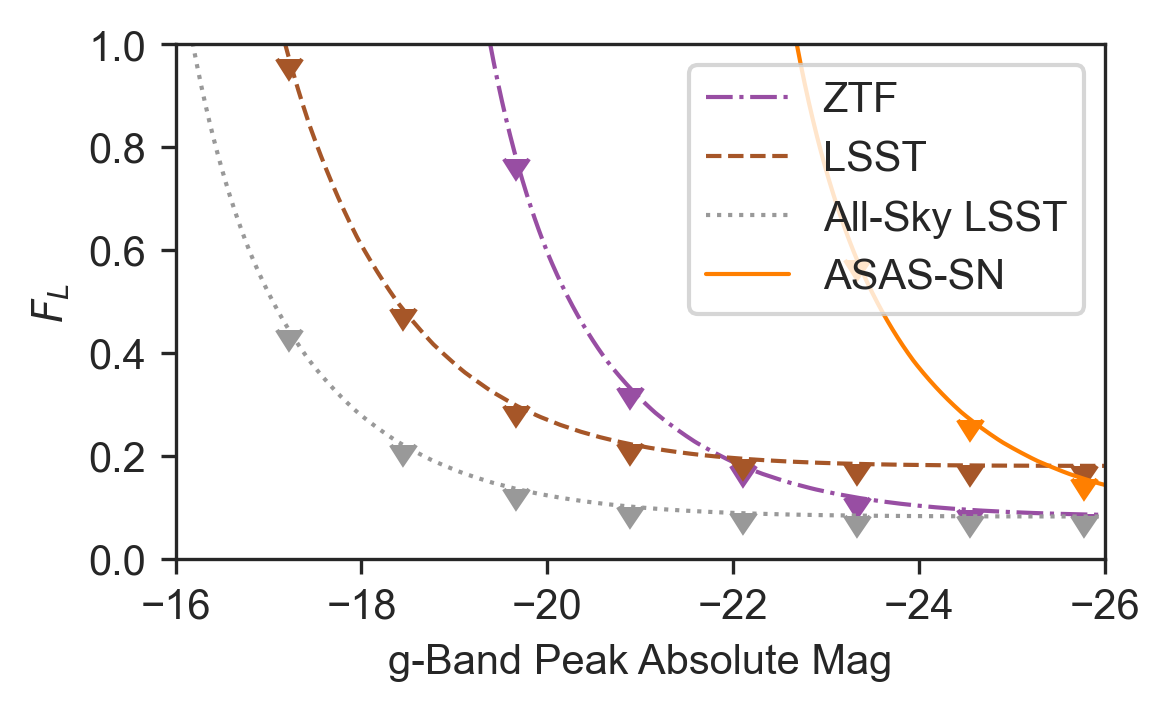

In [31]:
f = cdf_mpc["SFR"]
t = '14d'

fig, ax = plt.subplots(
    figsize=(base_width, base_height), 
    dpi=dpi, 
    sharey='all',
    gridspec_kw={'wspace': 0}
)

abs_mag = np.linspace(-16, -27, 1000)

for inst, d in uls.items():
    
    # if inst == 'ASAS-SN':
    #     compmag = asassn_comp_mag
    #     color = asassn_color
    #     ls = "-"
    #     lw = 1.5
    # else:
    compmag = instruments[inst][1]
    color = instruments[inst][2]
    ls = instruments[inst][3]
    lw = 1
    
    def max_f(abs_mags):
        res = d[t]/f(max_dl(abs_mags, compmag))
        return res
    
    ax.plot(abs_mag, max_f(abs_mag), label=inst, color=color, ls=ls, lw=lw)
    mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
    eb = ax.errorbar(
        mag_scatter, 
        max_f(mag_scatter), 
        yerr=0.0, 
        uplims=True, 
        color=color, 
        linestyle="",
        capsize=0, 
        mew=1
    )
    
ax.set_xlim((max(abs_mag), min(abs_mag)+1))
ax.set_ylim((0, 1))
ax.legend()
ax.set_xlabel('g-Band Peak Absolute Mag')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fn = os.path.join(output_folder, "future_inst.pdf")
print(fn)
fig.savefig(fn)

plt.show()

## Use the actual ZTF results

/Users/jannisnecker/ASASSN_nu_paper_figures/future_inst_ztf_res.pdf


/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/2062676029.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/2062676029.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))


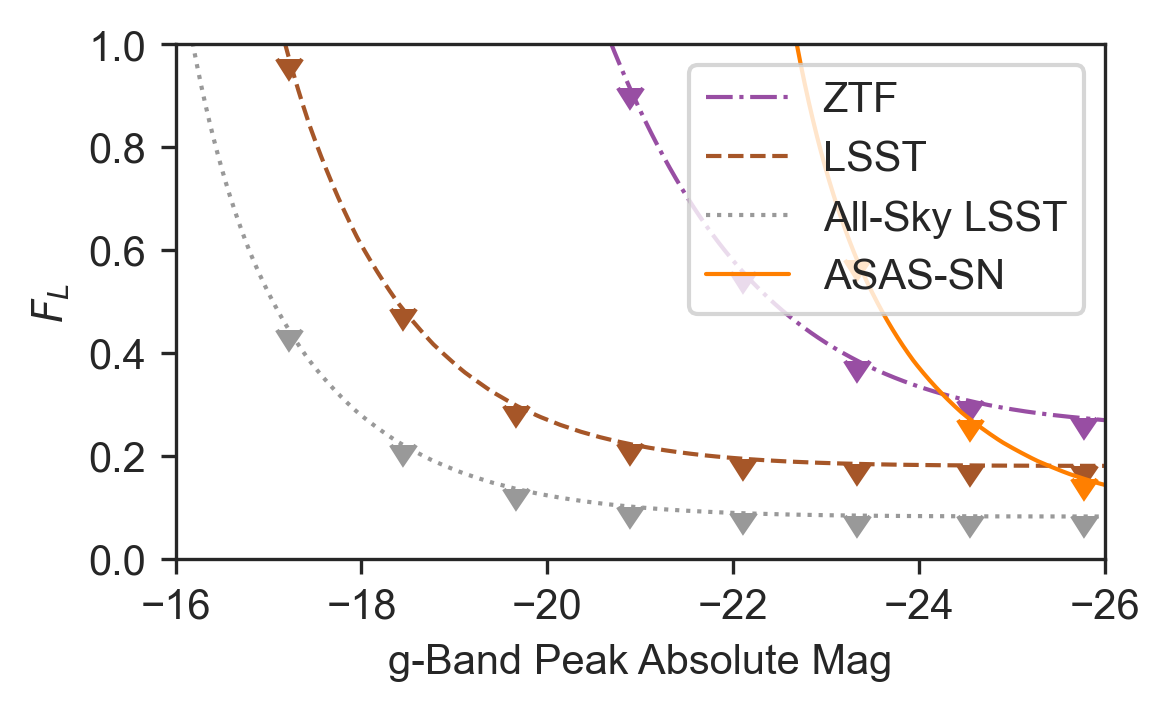

In [32]:
evolution = "SFR"
f = cdf_mpc[evolution]
t = "14d"

fig, ax = plt.subplots(
    figsize=(base_width, base_height), 
    dpi=dpi, 
    sharey='all',
    gridspec_kw={'wspace': 0}
)

for inst, d in uls.items():
    
    # if inst == 'ASAS-SN':
    #     compmag = asassn_comp_mag
    #     color = asassn_color
    #     ls = "-"
    #     lw = 1.5
    # else:
    compmag = instruments[inst][1]
    color = instruments[inst][2]
    ls = instruments[inst][3]
    lw = 1
    
    if inst == 'ZTF':
        dat = pd.read_csv(f"data/ztf_nu_{evolution.lower()}.csv", sep=";", decimal=",", names=["abs_mag", "f"])
        poly_coeff = np.polyfit(dat.abs_mag, dat.f, 6)
        max_f = np.poly1d(poly_coeff)
    else:
        def max_f(abs_mags):
            res = d[t]/f(max_dl(abs_mags, compmag))
            return res
    
    abs_mag = np.linspace(-16, -27, 1000)
    mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
    ax.plot(abs_mag, max_f(abs_mag), label=inst, color=color, ls=ls, lw=lw)
    eb = ax.errorbar(
        mag_scatter, 
        max_f(mag_scatter), 
        yerr=0.0, 
        uplims=True, 
        color=color, 
        linestyle="",
        capsize=0, 
        mew=1
    )
    
ax.set_xlim((max(abs_mag), min(abs_mag)+1))
ax.set_ylim((0, 1))
ax.legend(
    # bbox_to_anchor = (0.5,0.99), 
    # bbox_transform = fig.transFigure, 
    # loc='upper center', 
    # ncol=4
)
ax.set_xlabel('g-Band Peak Absolute Mag')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fn = os.path.join(output_folder, "future_inst_ztf_res.pdf")
print(fn)
fig.savefig(fn)

plt.show()

## Real ASAS-SN meas, real ZTF meas, LSST projected from ASAS-SN

In [85]:
uls_assasn_res

{'ZTF': {'24h': array(0.21786616), '14d': array(0.08279157)},
 'LSST': {'24h': array(0.59643797), '14d': array(0.18101972)},
 'All-Sky LSST': {'24h': array(0.22869927), '14d': array(0.08279157)},
 'ASAS-SN': {'1h': array(0.59235191),
  '2h': array(0.39285012),
  '4h': array(0.34533338),
  '24h': array(0.15301986),
  '14d': array(0.10259228)}}

In [86]:
from collections import OrderedDict

In [88]:
ordereD_uls_asassn_res = OrderedDict(uls_assasn_res)
for k in ["ASAS-SN", "ZTF", "LSST", "All-Sky LSST"]:
    ordereD_uls_asassn_res.move_to_end(k)

ordereD_uls_asassn_res

OrderedDict([('ASAS-SN',
              {'1h': array(0.59235191),
               '2h': array(0.39285012),
               '4h': array(0.34533338),
               '24h': array(0.15301986),
               '14d': array(0.10259228)}),
             ('ZTF', {'24h': array(0.21786616), '14d': array(0.08279157)}),
             ('LSST', {'24h': array(0.59643797), '14d': array(0.18101972)}),
             ('All-Sky LSST',
              {'24h': array(0.22869927), '14d': array(0.08279157)})])

/Users/jannisnecker/ASASSN_nu_paper_figures/future_inst_ztf_res_asasn_res.pdf


/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/3172864347.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/3172864347.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))


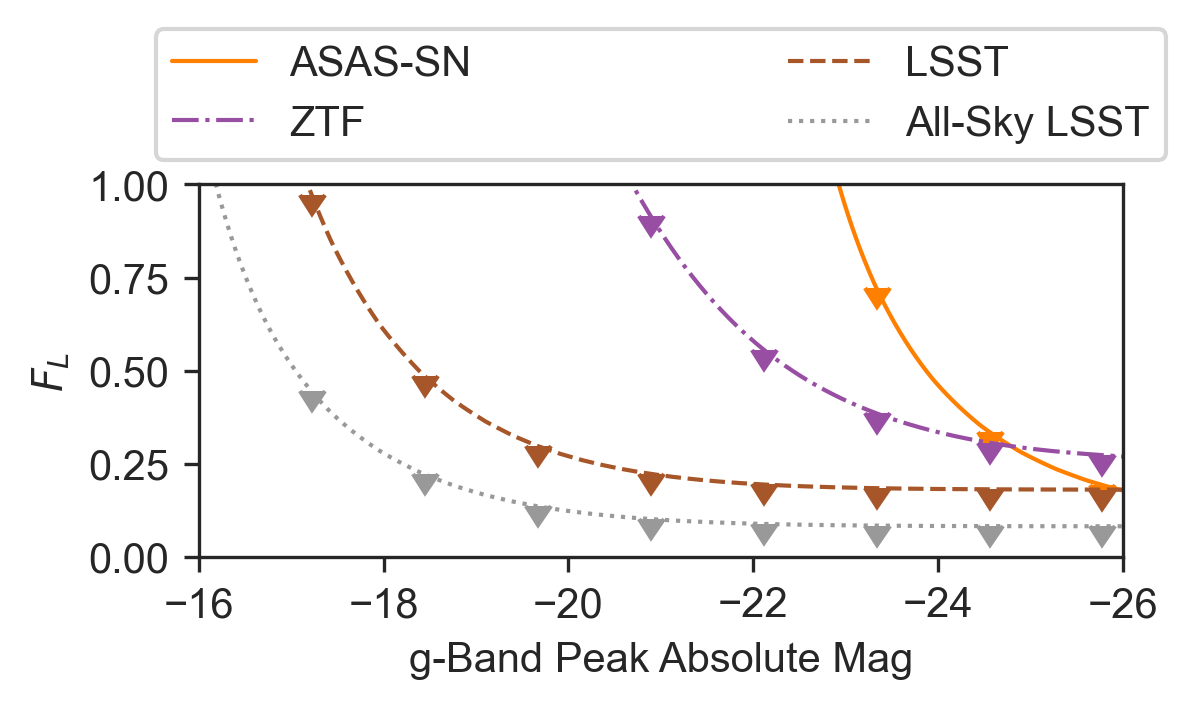

In [90]:
evolution = "SFR"
f = cdf_mpc[evolution]
t = "14d"

fig, ax = plt.subplots(
    figsize=(base_width, base_height), 
    dpi=dpi, 
    sharey='all',
    gridspec_kw={'wspace': 0}
)

for inst, d in ordereD_uls_asassn_res.items():
    
    # if inst == 'ASAS-SN':
    #     compmag = asassn_comp_mag
    #     color = asassn_color
    #     ls = "-"
    #     lw = 1.5
    # else:
    compmag = instruments[inst][1]
    color = instruments[inst][2]
    ls = instruments[inst][3]
    lw = 1
    
    if inst == 'ZTF':
        dat = pd.read_csv(f"data/ztf_nu_{evolution.lower()}.csv", sep=";", decimal=",", names=["abs_mag", "f"])
        poly_coeff = np.polyfit(dat.abs_mag, dat.f, 6)
        max_f = np.poly1d(poly_coeff)
    else:
        def max_f(abs_mags):
            res = d[t]/f(max_dl(abs_mags, compmag))
            return res
    
    abs_mag = np.linspace(-16, -27, 1000)
    mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
    ax.plot(abs_mag, max_f(abs_mag), label=inst, color=color, ls=ls, lw=lw)
    eb = ax.errorbar(
        mag_scatter, 
        max_f(mag_scatter), 
        yerr=0.0, 
        uplims=True, 
        color=color, 
        linestyle="",
        capsize=0, 
        mew=1
    )
    
ax.set_xlim((max(abs_mag), min(abs_mag)+1))
ax.set_ylim((0, 1))
ax.legend(
    bbox_to_anchor = (0.5, 1.01), 
    # bbox_transform = fig.transFigure, 
    loc='lower center', 
    ncol=2,
    # borderaxespad=0.,
    # mode="expand",
    columnspacing=7.6
)
ax.set_xlabel('g-Band Peak Absolute Mag')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()

# fig.subplots_adjust(bottom=0.2)
# fig.subplots_adjust(top=0.7)
# fig.subplots_adjust(left=0.1)

fn = os.path.join(output_folder, "future_inst_ztf_res_asasn_res.pdf")
print(fn)
fig.savefig(fn)

plt.show()

## Real ZTF meas, others projected with ZTF livetime

/Users/jannisnecker/ASASSN_nu_paper_figures/future_inst_ztf_res_ztf_time.pdf


/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/1147698928.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))
/var/folders/8r/3ym_r27d6hz1tw5wqp1x8dqr0000gn/T/ipykernel_3464/1147698928.py:31: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))


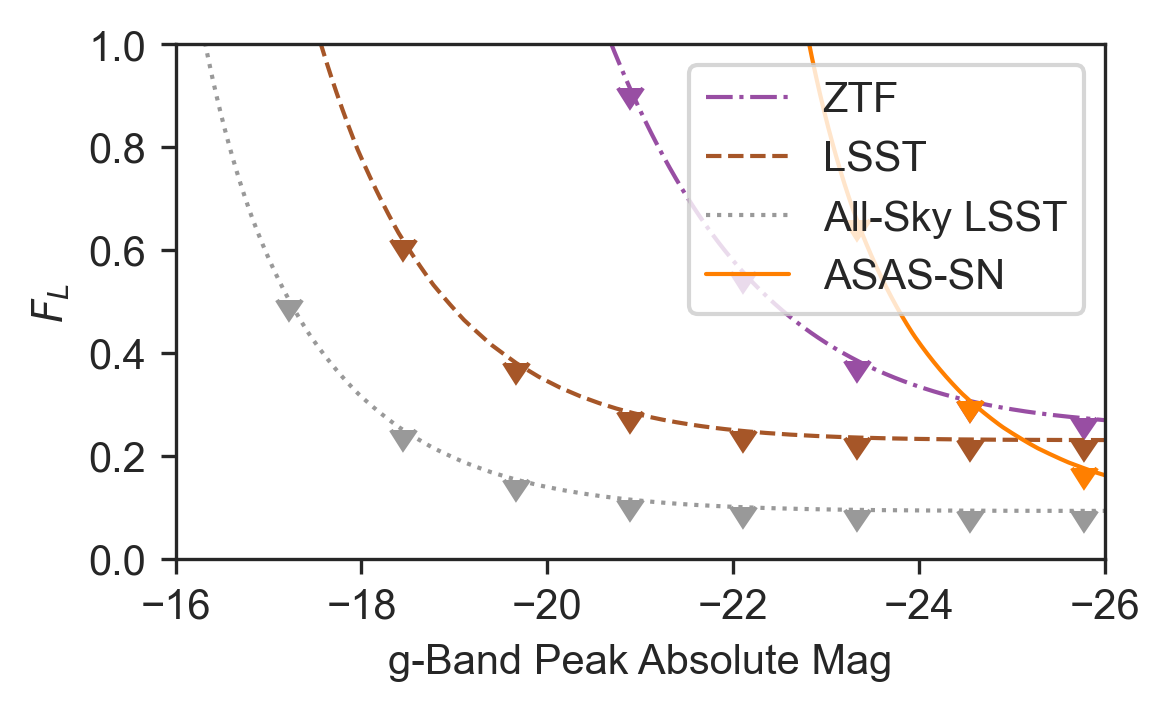

In [34]:
evolution = "SFR"
f = cdf_mpc[evolution]
t = "14d"

fig, ax = plt.subplots(
    figsize=(base_width, base_height), 
    dpi=dpi, 
    sharey='all',
    gridspec_kw={'wspace': 0}
)

for inst, d in uls_time_masked.items():
    
    # if inst == 'ASAS-SN':
    #     compmag = asassn_comp_mag
    #     color = asassn_color
    #     ls = "-"
    #     lw = 1.5
    # else:
    compmag = instruments[inst][1]
    color = instruments[inst][2]
    ls = instruments[inst][3]
    lw = 1
    
    if inst == 'ZTF':
        dat = pd.read_csv(f"data/ztf_nu_{evolution.lower()}.csv", sep=";", decimal=",", names=["abs_mag", "f"])
        poly_coeff = np.polyfit(dat.abs_mag, dat.f, 6)
        max_f = np.poly1d(poly_coeff)
    else:
        def max_f(abs_mags):
            res = d[t]/f(max_dl(abs_mags, compmag))
            return res
    
    abs_mag = np.linspace(-16, -27, 1000)
    mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
    ax.plot(abs_mag, max_f(abs_mag), label=inst, color=color, ls=ls, lw=lw)
    eb = ax.errorbar(
        mag_scatter, 
        max_f(mag_scatter), 
        yerr=0.0, 
        uplims=True, 
        color=color, 
        linestyle="",
        capsize=0, 
        mew=1
    )
    
ax.set_xlim((max(abs_mag), min(abs_mag)+1))
ax.set_ylim((0, 1))
ax.legend(
    # bbox_to_anchor = (0.5,0.99), 
    # bbox_transform = fig.transFigure, 
    # loc='upper center', 
    # ncol=4
)
ax.set_xlabel('g-Band Peak Absolute Mag')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fn = os.path.join(output_folder, "future_inst_ztf_res_ztf_time.pdf")
print(fn)
fig.savefig(fn)

plt.show()

## Deprecated

In [10]:
full_sky_sqd = 41252.961
# the list elements: observable sky fraction, completeness magnitude, color, linestyle
instruments = {
    'ZTF': [23675 / full_sky_sqd, 20.8, CB_color_cycle[5], "-."],
    'LSST': [20000 / full_sky_sqd, 25, CB_color_cycle[4], "--"],
    'All-Sky LSST': [1, 25, CB_color_cycle[6], ":"]
}
instruments

{'ZTF': [0.5738981984832555, 20.8, '#984ea3', '-.'],
 'LSST': [0.48481368404076497, 25, '#a65628', '--'],
 'All-Sky LSST': [1, 25, '#999999', ':']}

In [11]:
uls = dict()
ts = ['24h']
Ntrials = 100


for inst, info in instruments.items():
    
    print(f'---------- {inst} -----------')
    
    ul_samples = list()
    
    for i in tqdm.tqdm(range(Ntrials)):
        
        sample = observed.sample(frac=info[0])

        def P_det(f, t):
            P = 1
            for i, r in sample.iterrows():
                if r.Event == 'IC160731A' and r.Class == 'HESE':
                    continue
                P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f
            return P

        fs = np.linspace(0, 1, 1000)
        Ps = {t: [P_det(f, t) for f in fs] for t in ts}

        inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

        cl = 0.9
        pval = 1-cl

        ul_sample = {t: ip(pval) for t, ip in inverse_pdet.items()} 
        for t, iul in ul_sample.items():
            print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')
            
        """
        for t, iPs in Ps.items():
            fig, ax = plt.subplots()#figsize=(base_width, base_height), dpi=dpi)
            ax.plot(fs, iPs, color='k')
            plt.axhline(pval)
            plt.axvline(ul_sample[t])
            # plt.yscale('log')
            ax.set_xlim((0, 1))
            ax.set_title(t)
            plt.show()
            plt.close()
        """
            
        ul_samples.append(ul_sample)
            
    ul = {t: np.median([ul_sample[t] for ul_sample in ul_samples])
         for t in ts}
        
    uls[inst] = ul

---------- ZTF -----------


  0%|                                                                                                                                                      | 0/100 [00:00<?, ?it/s]


NameError: name 'observed' is not defined